In [1]:
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

try:
    from rikabplotlib.plot_utils import newplot, stamp, add_whitespace
except ImportError:
    from utils.plot_utils import newplot, stamp, add_whitespace
from utils.data_utils import load_data
from config import base_dir


from sklearn.metrics import roc_auc_score, roc_curve

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

2024-03-08 01:30:33.550961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


Num GPUs Available:  0
GPUs Available:  []


# Parameters and Data

Define the observable $\mathcal{O}^{(n)} = \sum_i z_i (c_1 + c_2 \log^n(\theta_i + c_3))$

In [6]:
# Parameters 
train = 1#2500
val = 1#25000
test = 1#25000
k_order = 1

epochs = 50
batch_size=512
callbacks =None
verbose = 2

# directory = f"/n/home01/rikab/moment/models/O{k_order}/"
###########

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [k_order,] #
input_dim = 2
output_dim = 1


max_L = 2**(8-k_order)
F_width = 100
Phi_width = 100


def log_features(x):


    a = -3.5
    b = -1.0
    c = 0.005

    zs = x[:,0]

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    # ls = rs

    l_list = []

    for n in range(4 + 1):

        l_list.append(np.sum(zs * np.power(ls, n)))
    


    return l_list




# Data 
X, Y = load_data("qg", train, val, test)

print("Data loaded!")


def cumulants(x):

    x[4,:] = np.nan_to_num(np.power(x[4,:] - 4*x[3,:]*x[1,:] - 3*x[2,:]**2 + 12*x[2,:]*x[1,:]**2 - 6*x[1,:]**4, 1/2))
    x[3,:] = np.nan_to_num(np.power(x[3,:] - 3*x[2,:]*x[1,:] + 2*x[1,:]**3, 1/3))
    x[2,:] = np.nan_to_num(np.power(x[2,:] - x[1,:]**2, 1/4))

    return x

# Data 
X, Y = qg_jets.load(train+val+test)

print("Data loaded!")


X = X[:,:,:3].astype(np.float32)
Y2 = to_categorical(Y, num_classes=2)
features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append((log_features(x)))

features = cumulants(np.array(features))





AssertionError: bad parameters: negative num_train

# Tensorflow fit

Fit to the function:

$F(\mathcal{O}) = \sigma(w_0 + \sum_{i=1}^k w_i(\mathcal{O}^{(i)} - c_i)^2)$

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

class CustomLayer(Layer):
    def __init__(self, input_dim):
        super(CustomLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(input_dim, 1), initializer="random_normal", trainable=True)

    def call(self, inputs):
        return tf.reduce_sum(self.w[:, 0] * (inputs - self.b[:, 0])**2, axis=-1)

def custom_loss(y_true, y_pred):
    return tf.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

def train_model(k_order):

    # Data preparation 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(features[:, 0:k_order+1], Y, val=val, test=test)

    # Model setup
    input_shape = (k_order+1,)  
    input_data = Input(shape=input_shape)
    custom_layer = CustomLayer(input_shape[0])
    cl = custom_layer(input_data)
    output = tf.sigmoid(cl)
    model = Model(inputs=input_data, outputs=output)

    # Training setup
    optimizer = Adam(learning_rate=0.005)
    batch_size = 512
    epochs = 100

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = custom_loss(y_batch, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Validation
        if (epoch + 1) % 10 == 0:
            y_pred = model.predict(X_val)
            auc = roc_auc_score(Y_val, y_pred)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}, AUC: {auc}")

    # Get the optimized values of w and c
    optimized_w = custom_layer.w.numpy()
    optimized_b = custom_layer.b.numpy()
    print("Optimized w:", optimized_w)
    print("Optimized b:", optimized_b)

    return model

782/782 [==============================] - 1s 634us/step
Epoch 10/100, Loss: 0.6843222379684448, AUC: 0.5693906321764002
782/782 [==============================] - 0s 529us/step
Epoch 20/100, Loss: 0.6611440777778625, AUC: 0.6939094289640815
517/782 [==================>...........] - ETA: 0s

KeyboardInterrupt: 

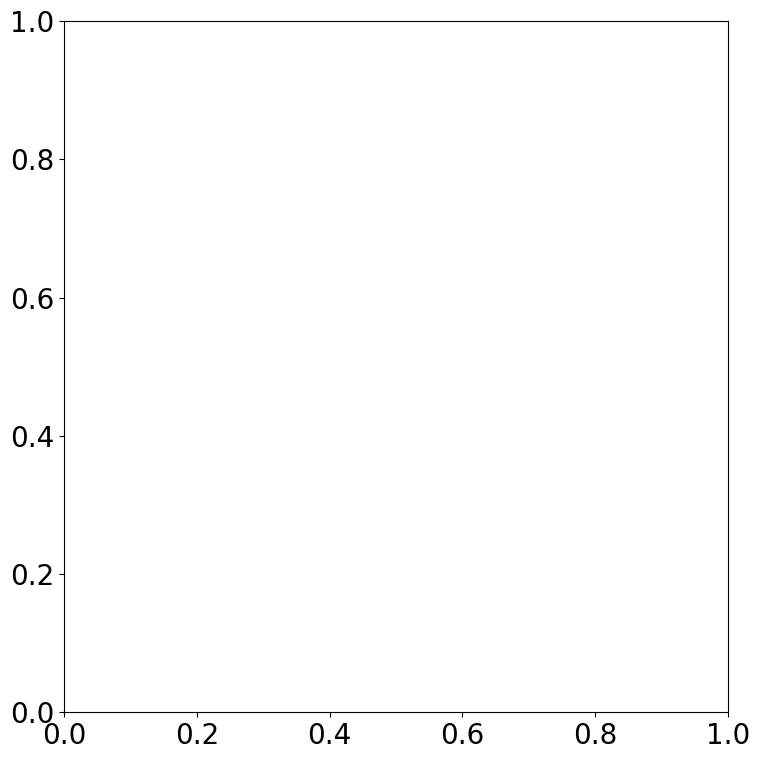

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

newplot()
colors = ["red", "orange", "green", "blue", "purple"]

for k in [1, 2, 3, 4]:

    for i in range(num_models_to_train):


        (X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(features[:, 0:k+1], Y, val=val, test=test)
        model = train_model(k)


        # Predict probabilities using the model
        y_pred_prob = model.predict(X_test)

        # Compute ROC curve and ROC area
        fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Save ROC curve data
        np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}.npy", np.array([fpr, tpr, thresholds, roc_auc]))

        # Plot ROC curve
    
        plt.plot(tpr, 1-fpr, color=colors[k-1], lw=3, label=f'$k = {k}$' +  ', AUC = %0.3f' % roc_auc)
        # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


$k = 1$ Log Ang. Closed Form& 0.725 $\pm$ 0.001 & 36.2 $\pm$ 0.2 & 7.0 $\pm$ 0.0 & $3+1$ \\
$k = 2$ Log Ang. Closed Form& 0.780 $\pm$ 0.002 & 57.4 $\pm$ 0.2 & 10.6 $\pm$ 0.1 & $3+3$ \\
$k = 3$ Log Ang. Closed Form& 0.781 $\pm$ 0.002 & 57.8 $\pm$ 2.8 & 12.1 $\pm$ 0.1 & $3+5$ \\
$k = 4$ Log Ang. Closed Form& 0.793 $\pm$ 0.002 & 54.6 $\pm$ 1.7 & 12.7 $\pm$ 0.4 & $3+7$ \\


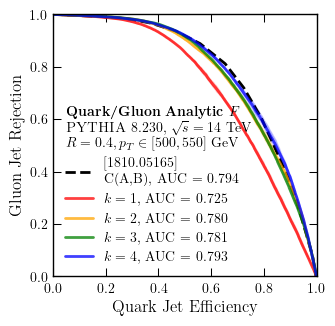

In [12]:
# Load and plot ROC curve data
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fig, ax = newplot("column")


# ########## Digitized C(A,B) ##########
digitialized = np.genfromtxt("Data_old/original_efn_fit.csv", delimiter=",")
digitized_tpr = digitialized[:,0]
digitized_fpr = np.power(digitialized[:,1], 1.02)
digitized_auc =  auc(digitized_tpr, digitized_fpr)

plt.plot(digitized_tpr, digitized_fpr, color="black", lw=2, ls = "--", label="[1810.05165]\nC(A,B), AUC = %0.3f" % digitized_auc)


# Moments 
colors = ["red", "orange", "green", "blue", "purple"]
for k in [1, 2, 3, 4]:

    # Average ROC curve over multiple model
    x_axis = np.linspace(0, 1, 1000)
    fprs = []
    tprs = []
    aucs = []
    e30 = []
    e50 = []

    latex_line = f"$k = {k}$ Log Ang. Closed Form&"  # Start the LaTeX line
    for i in range(num_models_to_train):
            
            if k == 2 and i == 2:
                continue
            
            # Load ROC curve data
            fpr, tpr, thresholds, roc_auc = np.load(f"Data_old/analytic/roc_curve_data_k{k}_i{i}_O{k}.npy", allow_pickle=True)

            # Append to lists by interpolating 
            fprs.append(np.interp(x_axis, tpr, 1-fpr))
            tprs.append(x_axis)
            aucs.append(roc_auc)


                # print ROC table info



            num_parameters = 2 * (k) + 1 - 2



            e30.append(1/np.interp(0.3, tpr, fpr))
            e50.append(1/np.interp(0.5, tpr, fpr))

    aucs = np.asarray(aucs)
    e30 = np.asarray(e30)
    e50 = np.asarray(e50)

    # Format for LaTeX table
    latex_line += f" {np.mean(aucs):.3f} $\pm$ {np.std(aucs)/np.sqrt(1):.3f} & {np.mean(e30):.1f} $\pm$ {np.std(e30)/np.sqrt(num_models_to_train):.1f} & {np.mean(e50):.1f} $\pm$ {np.std(e50)/np.sqrt(num_models_to_train):.1f} & $3+{num_parameters}$ \\\\"
    print(latex_line)

    # Average ROC curve
    fpr_avg = np.average(fprs, axis=0)
    tpr_avg = np.average(tprs, axis=0)
    auc_avg = np.average(aucs)

    # Standard deviation of ROC curve
    fpr_std = np.std(fprs, axis=0)
    auc_std = np.std(aucs)    
    

    # Plot ROC curve with error band
    plt.plot(tpr_avg, fpr_avg, color=colors[k-1], lw=2, label=f'$k = {k}$' +  ', AUC = %0.3f' % auc_avg, alpha = 0.75)
    plt.fill_between(tpr_avg, fpr_avg - fpr_std, fpr_avg + fpr_std, color=colors[k-1], alpha=0.2)




# Stamp
line_0 = "Quark/Gluon Analytic $F$"
line_1 = r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
line_2 = "$R = 0.4, p_T \in [500, 550]$ GeV"
stamp(0.05, 0.625, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"fontsize": 9})


# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False, fontsize = 9)

plt.savefig(f"Plots/analytic_F.pdf", bbox_inches="tight")



In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Model input and placeholders for w and c
input_shape = (4,)  
input_data = Input(shape=input_shape)

b1_i = tf.Variable(tf.random.normal((4,1), mean=0.0, stddev=1), trainable=True, name="bias_numerator")

w1_i = tf.Variable(tf.random.normal((4,1), mean=0.0, stddev=1), trainable=True, name="weights_numerator")
i
numerator = tf.reduce_sum(w1_i[:,0] * (input_data - b1_i[:,0])**2, axis = -1) 

# layer = tf.reduce_sum([layer, w_0])
output = tf.sigmoid(numerator)

# Build the model
model = Model(inputs=input_data, outputs=output)

# BCE loss
def custom_loss(y_true, y_pred):
    return tf.losses.binary_crossentropy(y_true, y_pred, from_logits=False)



In [31]:
import warnings
warnings.filterwarnings("ignore")

k_order = 4
(X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,1:k_order+1], Y, val=val, test=test)

print(X_train.shape)
batch_size = 512

for epoch in range(100):

    for i in range(0, len(X_train), batch_size):
    
        x_batch = X_train[i:i+batch_size]
        y_batch = Y_train[i:i+batch_size]

        # Compute gradients with respect to w and c
        with tf.GradientTape() as tape:
            predictions = model(x_batch)
            loss = custom_loss(y_batch, predictions)

        gradients = tape.gradient(loss, [w1_i, b1_i])

        # Create an optimizer
        optimizer = Adam(learning_rate=0.001)

        # Apply gradients to variables
        optimizer.apply_gradients(zip(gradients, [w1_i, b1_i]))


    if (epoch + 1) % 1 == 0:
        y_pred = model(X_val)
        auc = roc_auc_score(Y_val, y_pred)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}, AUC: {auc}")


# Get the optimized values of w and c
optimized_w1 = w1_i.numpy()
optimized_b1 = b1_i.numpy()

print("Optimized w1_i:", optimized_w1)
print("Optimized b1:", optimized_b1)


(250000, 4)


ValueError: No gradients provided for any variable: (['weights_numerator:0', 'bias_numerator:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'weights_numerator:0' shape=(4, 1) dtype=float32, numpy=
array([[-1.0729703],
       [-1.3885167],
       [ 1.4634117],
       [-1.1090738]], dtype=float32)>), (None, <tf.Variable 'bias_numerator:0' shape=(4, 1) dtype=float32, numpy=
array([[1.0695764],
       [1.0508679],
       [1.0943109],
       [0.6410818]], dtype=float32)>)).